# CARDIOVASCULAR CATH DISEASE

## The Cardio Catch Diseases (CCD) Company
Cadio Catch Diseases is a company that specializes in detecting heart disease in the early stages. Its business model is Service type, that is, the company offers an early diagnosis of cardiovascular disease for a certain price.

Currently, the diagnosis of cardiovascular disease is made manually by a team of specialists. The current accuracy of the diagnosis varies between 55% and 65%, due to the complexity of the diagnosis and also the fatigue of the team who take turns to minimize the risks. The cost of each diagnosis, including the devices and the payroll of the analysts, is around R $ 1,000.00.

The price of the diagnosis, paid by the client, varies according to the precision achieved by the team of specialists, the client pays R $ 500.00 for every 5% accuracy above 50%. For example, for an accuracy of 55%, the diagnosis costs R $ 500.00 for the client, for an accuracy of 60%, the value is R $ 1000.00 and so on. If the diagnostic accuracy is 50%, the customer does not pay for it.

Note that the variation in precision given by the team of specialists, makes the company either have a profitable operation, revenue greater than the cost, or an operation at a loss, revenue less than the cost. This instability of the diagnosis makes the company to have an unpredictable Cashflow.

Your objective as the Data Scientist hired by Cardio Catch Diseases is to create a tool that increases the accuracy of the diagnosis and that this accuracy is stable for all diagnoses.

So your job as a Data Scientist is to create a patient classification tool, such as stable accuracy. Along with the tool, you need to send a report to the CEO of Cardio Catch Diseases, reporting the results and answering the following questions: (He will probably ask these questions on the day of your presentation.)

What is the Accuracy and Precision of the tool?
How much profit will Cardio Catch Diseases have with the new tool?
How Reliable is the result given by the new tool?
The Challenge Data
The data set that will be used to create the solution for Cardio Catch Diseases, is available on the Kaggle platform.

This is the link: Cardiovascular Disease dataset

This data set contains 70,000 patient diagnoses. You will use this data to create your solution.

# 0.0 IMPUTS

## 0.1 Imports

In [152]:
import csv
import pickle
import warnings
warnings.filterwarnings( 'ignore' )

import numpy               as np
import pandas              as pd
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec


from tabulate              import tabulate
from IPython.display       import Image
from IPython.core.display  import HTML
from scipy                 import stats     as ss

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, Normalizer

## 0.2 Helpers Functions

In [2]:
np.random.seed(42)

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

In [3]:
def calcBMI(weight, height):
    #BMI = kg/m2
    bmi = np.round(weight / (height**2), 1)
    
    return bmi

def BMI(bmi):
    if bmi < 18.5:
        status = "Underweight"
    
    elif bmi >= 18.5 and bmi <= 24.9:
        status = "Healthy"
    
    elif bmi >= 25.0 and bmi <= 29.9:
        status = "Overweight"
        
    elif bmi >= 30.0:
        status = "Obese"
        
    return status

In [4]:
def cramer_v(x,y):

    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r , k = cm.shape

    chi2 = ss.chi2_contingency ( cm )[0]
    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
        
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1) ))

## 0.3 Loading Data

In [5]:
df_cardio_raw = pd.read_csv('data/cardio_train.csv', low_memory= False, delimiter=';')

# 1.0 DATA DESCRIPTION

In [6]:
df1 = df_cardio_raw.copy()

In [7]:
df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 1.1 Features Description

There are 3 types of input features:

**Objective:** factual information;

**Examination:** results of medical examination;

**Subjective:** information given by the patient.


### Features:

**- Age** | Objective Feature | age | int (days)

**- Height** | Objective Feature | height | int (cm) |

**- Weight** | Objective Feature | weight | float (kg) |

**- Gender** | Objective Feature | gender | categorical code |

**- Systolic blood pressure** | Examination Feature | ap_hi | int |

**- Diastolic blood pressure** | Examination Feature | ap_lo | int |

**- Cholesterol** | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |

**- Glucose** | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |

**- Smoking** | Subjective Feature | smoke | binary |

**- Alcohol intake** | Subjective Feature | alco | binary |

**- Physical activity** | Subjective Feature | active | binary |

**- Presence or absence of cardiovascular disease** | Target Variable | cardio | binary |


All of the dataset values were collected at the moment of medical examination.

## 1.2 Rename Columns

In [8]:
new_columns = {"ap_hi": "systolic_blood_pressure", "ap_lo": "diastolic_blood_pressure", "gluc": "glucose",
              "smoke": "smoking", "alco": "alcohol", "active": "physical_activity", "cardio": "cardio_disease"}

df1.rename(columns=new_columns, inplace=True)

df1.head()

,id,age,gender,height,weight,systolic_blood_pressure,diastolic_blood_pressure,cholesterol,glucose,smoking,alcohol,physical_activity,cardio_disease
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 1.3 Data Dimentions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 70000
Number of cols: 13


## 1.4 Data Types

In [10]:
df1.dtypes

id                            int64
age                           int64
gender                        int64
height                        int64
weight                      float64
systolic_blood_pressure       int64
diastolic_blood_pressure      int64
cholesterol                   int64
glucose                       int64
smoking                       int64
alcohol                       int64
physical_activity             int64
cardio_disease                int64
dtype: object

## 1.5 Check NA

In [11]:
df1.isna().sum()

id                          0
age                         0
gender                      0
height                      0
weight                      0
systolic_blood_pressure     0
diastolic_blood_pressure    0
cholesterol                 0
glucose                     0
smoking                     0
alcohol                     0
physical_activity           0
cardio_disease              0
dtype: int64

## 1.6 Change Types

We're going to convert the age units from days to years so it becomes easier to interpret and check if there is any outlier. However, for the future calculations, we're going to keep the days column, because there's a chance that we may lose information by rounding the data.

In [12]:
# converting days to years
df1['age_years'] = ((df1['age'])/365).round(2)
df1.head()

,id,age,gender,height,weight,systolic_blood_pressure,diastolic_blood_pressure,cholesterol,glucose,smoking,alcohol,physical_activity,cardio_disease,age_years
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.39
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.42
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.66
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.28
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.87


**Gender** can be estimated by **height**, as men are on average taller than women of the same age.

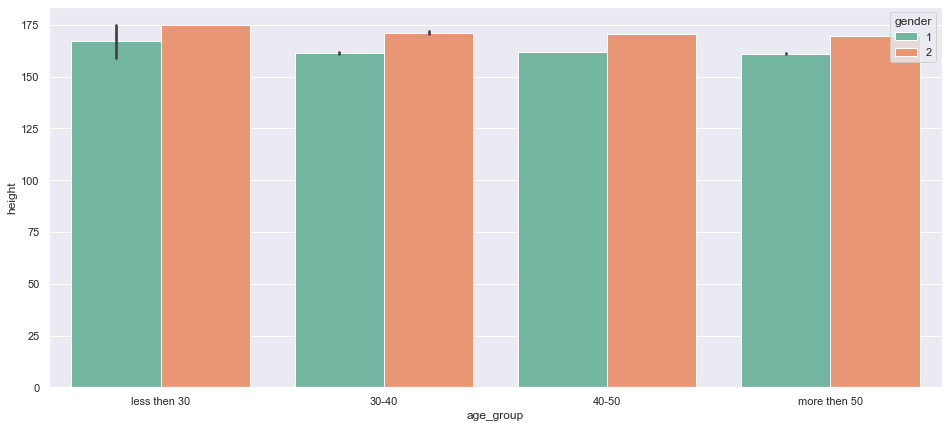

In [13]:
sns.set(rc={'figure.figsize':(16,7)})

df1['age_group'] = df1['age_years'].apply( lambda x: 'less then 30' if x <= 30 else 
                                         ( '30-40' if 30<x<= 40 else 
                                          ( '40-50' if 40<x<= 50 else 'more then 50' )))

sns.barplot( x = 'age_group', y = 'height', data = df1, hue = 'gender', palette = 'Set2', order = ['less then 30', '30-40', '40-50', 'more then 50']);

In [14]:
df1['gender'] = df1['gender'].apply( lambda x: 'women' if x == 2 else 'men')


# changing the descriptions contained at Features Description for exploratory data analysis:
df1['cholesterol'] = df1['cholesterol'].apply( lambda x: 'normal' if x == 1 else 'above normal' if x == 2 else 'well above normal')
df1['glucose'] = df1['glucose'].apply( lambda x: 'normal' if x == 1 else 'above normal' if x == 2 else 'well above normal')

# transforming float in int number:
df1['weight'] = df1['weight'].astype(int)

In [15]:
df1.dtypes

id                            int64
age                           int64
gender                       object
height                        int64
weight                        int32
systolic_blood_pressure       int64
diastolic_blood_pressure      int64
cholesterol                  object
glucose                      object
smoking                       int64
alcohol                       int64
physical_activity             int64
cardio_disease                int64
age_years                   float64
age_group                    object
dtype: object

**Data types :** float64 (1), int32 (1), int64 (9), object (4).

## 1.7 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32', 'float64'])

### 1.7.1 Numerical Attributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - Std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.00,99999.00,99999.00,49972.419900,50001.50,28851.096242,-0.001278,-1.198374
1,age,10798.00,23713.00,12915.00,19468.865814,19703.00,2467.234044,-0.307055,-0.823447
2,height,55.00,250.00,195.00,164.359229,165.00,8.210068,-0.642187,7.943653
3,weight,10.00,200.00,190.00,74.204329,72.00,14.395850,1.012030,2.586746
4,systolic_blood_pressure,-150.00,16020.00,16170.00,128.817286,120.00,154.010319,85.296214,7580.074738
5,diastolic_blood_pressure,-70.00,11000.00,11070.00,96.630414,80.00,188.471184,32.114083,1425.914585
6,smoking,0.00,1.00,1.00,0.088129,0.00,0.283482,2.905867,6.444250
7,alcohol,0.00,1.00,1.00,0.053771,0.00,0.225566,3.956607,13.655125
8,physical_activity,0.00,1.00,1.00,0.803729,1.00,0.397176,-1.529473,0.339296
9,cardio_disease,0.00,1.00,1.00,0.499700,0.00,0.500000,0.001200,-2.000056


In the data we can see possible outliers:


- Minimum **height** = 55.00, and minimum **weight** = 10.00, when **age_years** = 29.58;

- Maximum blood pressure **systolic_blood_pressure** = 16170.00 and **diastolic_blood_pressure** = 11070.00.
- Minimum blood pressure **systolic_blood_pressure** and **diastolic_blood_pressure** negatives.

### 1.7.2 Categorical Attributes

In [18]:
cat_attributes.apply( lambda x: x.unique().shape[0])

gender         2
cholesterol    3
glucose        3
age_group      4
dtype: int64

<AxesSubplot:xlabel='glucose', ylabel='count'>

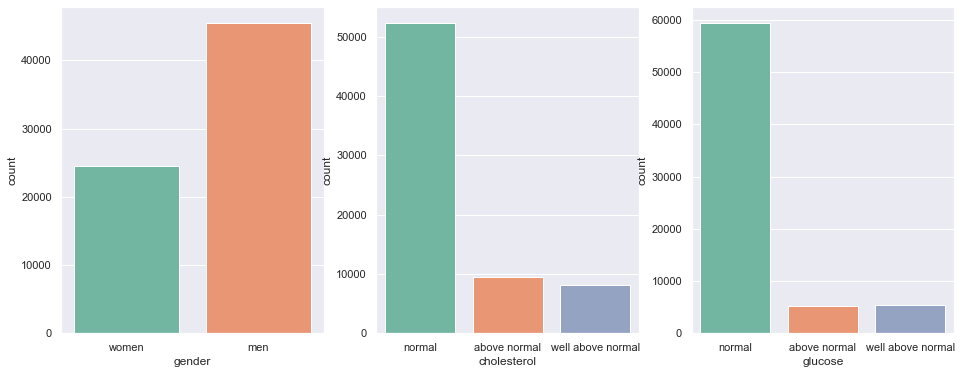

In [19]:
sns.set(rc={'figure.figsize':(16,6)})

plt.subplot(1,3,1)
sns.countplot(df1['gender'], palette = 'Set2')

plt.subplot(1,3,2)
sns.countplot(df1['cholesterol'], palette = 'Set2', order = ['normal', 'above normal', 'well above normal'])

plt.subplot(1,3,3)
sns.countplot(df1['glucose'], palette = 'Set2')


## 1.8 Outliers

### 1.8.1 Checking outliers

Text(0.5, 1.0, 'Weight x Height')

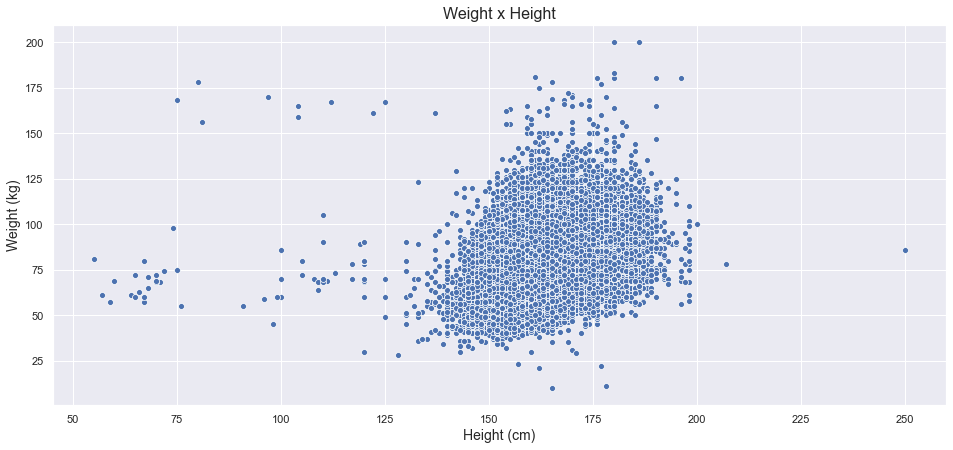

In [20]:
sns.set(rc={'figure.figsize':(16,7)})

sns.scatterplot(x="height", y="weight", data = df1)
plt.xlabel("Height (cm)", fontsize=14)
plt.ylabel("Weight (kg)", fontsize=14)
plt.title("Weight x Height", fontsize=16)

In this graph, we can see the presence of some outliers in addition to those we saw in the Numerical Attributes table. We will analyze the "height" and "weight" variables separately to define the outliers limits.

Text(0.5, 1.0, 'Weight x Age')

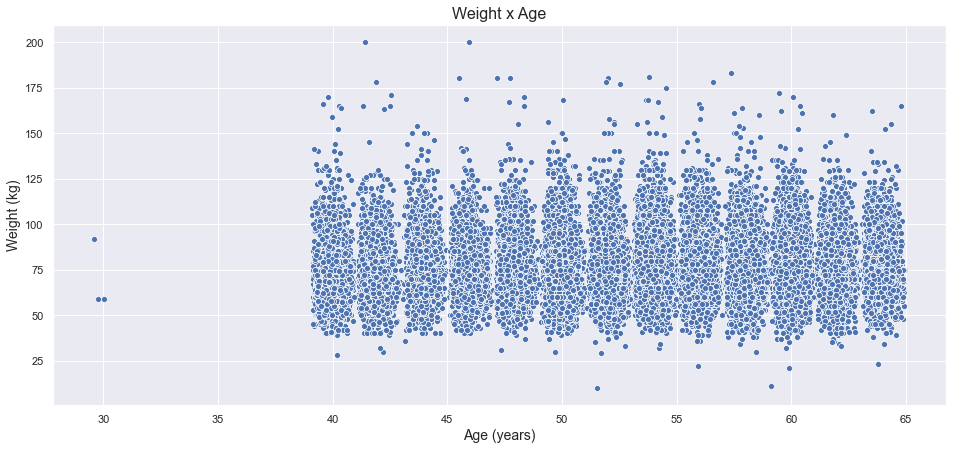

In [21]:
sns.set(rc={'figure.figsize':(16,7)})

sns.scatterplot(x='age_years', y='weight', data=df1)
plt.xlabel("Age (years)", fontsize=14)
plt.ylabel("Weight (kg)", fontsize=14)
plt.title("Weight x Age", fontsize=16)

**Ages** lower than 35 years will be considered outliers.

Points in **weight** lower then 40 kg, will be considered outliers.

Text(0.5, 1.0, 'Height x Age')

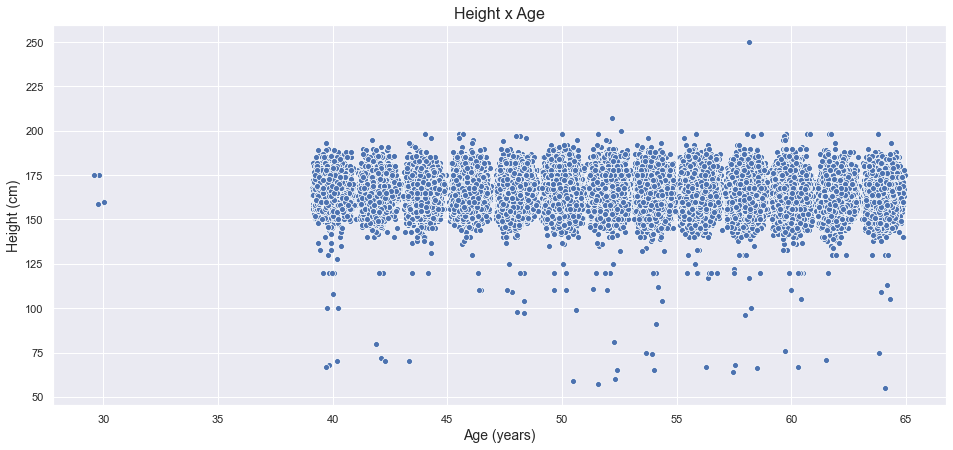

In [22]:
sns.set(rc={'figure.figsize':(16,7)})

sns.scatterplot(x='age_years', y='height', data=df1)
plt.xlabel("Age (years)", fontsize=14)
plt.ylabel("Height (cm)", fontsize=14)
plt.title("Height x Age", fontsize=16)

Points in **height**: x <= 110 cm  or  210 cm <= x, will be considered outliers.

Text(0.5, 1.0, 'Diastolic x Systolic')

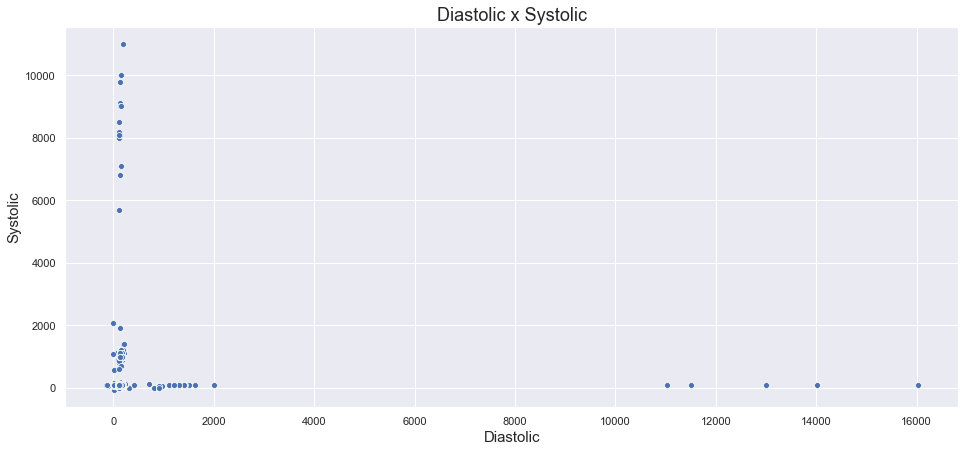

In [23]:
sns.set(rc={'figure.figsize':(16,7)})

sns.scatterplot(x='systolic_blood_pressure', y='diastolic_blood_pressure', data=df1)
plt.xlabel("Diastolic", fontsize=15)
plt.ylabel("Systolic", fontsize=15)
plt.title("Diastolic x Systolic", fontsize=18)

Points up to 210 for Diastolic and Systolic blood pressure, will be considered outliers.

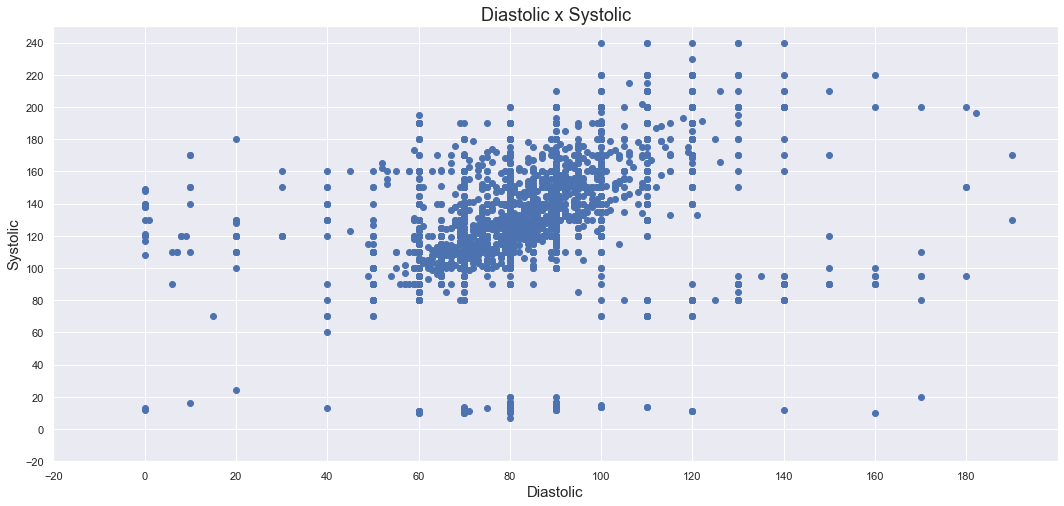

In [24]:
fig, ax = plt.subplots(figsize=(18,8))

plt.scatter(df1['diastolic_blood_pressure'],df1['systolic_blood_pressure'])
plt.xlabel("Diastolic", fontsize=15)
plt.ylabel("Systolic", fontsize=15)
plt.title("Diastolic x Systolic", fontsize=18)
start, end = ax.set_xlim([-20,200])
ax.xaxis.set_ticks(np.arange(start, end, 20))
start, end = ax.set_ylim([-20,250])
ax.yaxis.set_ticks(np.arange(start, end, 20))
ax.grid(True)

Points lower than 40 for Diastolic and 60 for Systolic blood pressure, will be considered outliers.

### 1.8.2 Removing Outliers

In [25]:
# removing outliers: blood pressure
df_new = df1[~((df1['systolic_blood_pressure'] > 210) | (df1['diastolic_blood_pressure'] > 150) 
           | (df1['systolic_blood_pressure'] < 60) | (df1['diastolic_blood_pressure'] < 40))]

# removing outliers: height
df_new = df_new[~((df_new['height'] <= 110) | (df_new['height'] >= 210))]

# removing outliers: weight
df_new = df_new[~(df_new['weight'] <= 40)]

# removing outliers: age
df_new = df_new[~(df_new['age_years'] < 35)]

df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68587 entries, 0 to 69999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        68587 non-null  int64  
 1   age                       68587 non-null  int64  
 2   gender                    68587 non-null  object 
 3   height                    68587 non-null  int64  
 4   weight                    68587 non-null  int32  
 5   systolic_blood_pressure   68587 non-null  int64  
 6   diastolic_blood_pressure  68587 non-null  int64  
 7   cholesterol               68587 non-null  object 
 8   glucose                   68587 non-null  object 
 9   smoking                   68587 non-null  int64  
 10  alcohol                   68587 non-null  int64  
 11  physical_activity         68587 non-null  int64  
 12  cardio_disease            68587 non-null  int64  
 13  age_years                 68587 non-null  float64
 14  age_gr

In [26]:
ratio_of_outliers_removed = 100 - (df_new.shape[0] / df1.shape[0]) * 100
print(f'Ratio of removed outliers: {round(ratio_of_outliers_removed, 2)}%')

Ratio of removed outliers: 2.02%


### 1.8.3 Exporting Data

In [27]:
df_new.to_csv('data/clean_data.csv', index=False)

# 2.0  FEATURE ENGENEERING

In [28]:
df2 = df_new.copy()

## 2.1 Mind Map Hypotheses

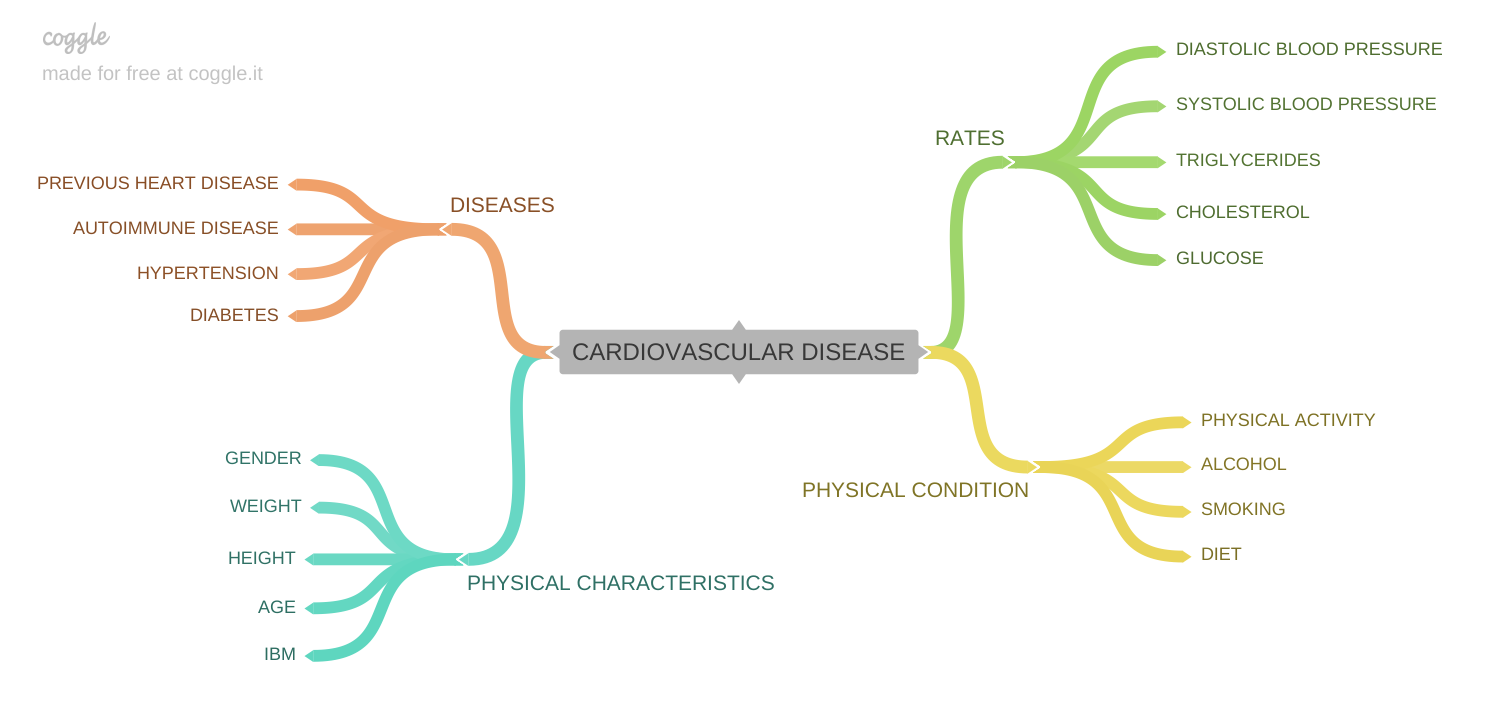

In [29]:
Image ('img/CARDIOVASCULAR_DISEASE.png')

## 2.2 Hypotheses criation

### 2.2.1 Diseases Hypotheses

**1.** People with a previous heart disease should have more cardio disease.

**2.** People with a family history of heart disease should have more cardio disease.

**3.** People with autoimmune diseases should have more cardio disease.

**4.** People with hipertension should have more cardio disease.

**5.** People with diabetes should have more cardio disease.

**6.** People with psychological illnesses like anxiety and depression should have more cardio disease.

### 2.2.2 Rates Hypotheses

**1.** People with systolic blood pressure higher then 140 should have more cardio disease.

**2.** People with systolic blood pressure lower then 90 should have more cardio disease.

**3.** People with diastolic blood pressure higher then 90 should have more cardio disease.

**4.** People with diastolic blood pressure lower then 60 should have more cardio disease.

**5.** People with triglycerides higher then 200mg/dL should have more cardio disease.

**6.** People with higher cholesterol should have more cardio disease.

**7.** People with glucose (fasting) higher then 125mg/dL should have more cardio disease.

### 2.2.3 Physical Characteristics Hypotheses

**1.** Men should have more cardio disease then women.

**2.** Obese people should have more cardio disease.

**3.** Height should not interfere with the likelihood of cardio disease.

**4.** Elderly people should have more cardio disease.

### 2.2.4 Physical Condition Hypotheses

**1.** People who practice physical activities should have less cardio disease.

**2.** People who drink should have more cardio disease.

**3.** People who smoke should have more cardio disease.

**4.** People who eat healthily should have less cardio disease.

## 2.3 Hypotheses final list

**1.** People with hipertension should have more cardio disease.

**2.** People with diabetes should have more cardio disease.


**3.** People with systolic blood pressure higher then 140 should have more cardio disease.

**4.** People with systolic blood pressure lower then 90 should have more cardio disease.

**5.** People with diastolic blood pressure higher then 90 should have more cardio disease.

**6.** People with diastolic blood pressure lower then 60 should have more cardio disease.

**7.** People with higher cholesterol should have more cardio disease.


**8.** Men should have more cardio disease then women.

**9.** Obese people should have more cardio disease.

**10.** Height should not interfere with the likelihood of cardio disease.

**11.** Elderly people should have more cardio disease.


**12.** People who practice physical activities should have less cardio disease.

**13.** People who smoke should have more cardio disease.

## 2.4 Hypotheses for Future Analysis

**1.** People with a previous heart disease should have more cardio disease.

**2.** People with a family history of heart disease should have more cardio disease.

**3.** People with autoimmune diseases should have more cardio disease.

**4.** People with psychological illnesses like anxiety and depression should have more cardio disease.

**5.** People with triglycerides higher then 200mg/dL should have more cardio disease.

**6.** People with glucose (fasting) higher then 125mg/dL should have more cardio disease.

**7.** People who drink should have more cardio disease.

**8.** People who eat healthily should have less cardio disease.

## 2.5 Feature Engeneering

In [30]:
df2["BMI"] = df2[["height", "weight"]].apply(lambda x: calcBMI(x["weight"], x["height"]/100), axis=1)
df2["weight_status"] = df2["BMI"].apply(BMI)

In [31]:
df2['blood_pressure_stage'] = df2.apply( lambda x: 'hypertensive crisis' if (x['systolic_blood_pressure'] > 180) | (x['diastolic_blood_pressure'] > 120) 
                                        else 'high (stage 2)' if ((x['systolic_blood_pressure'] >= 140) & (x['systolic_blood_pressure'] <= 180)) | 
                                        ((x['diastolic_blood_pressure'] >= 90) & (x['diastolic_blood_pressure'] <= 120))
                                        else 'high (stage 1)' if ((x['systolic_blood_pressure'] >= 130) & (x['systolic_blood_pressure'] <= 139)) | 
                                        ((x['diastolic_blood_pressure'] >= 80) & (x['diastolic_blood_pressure'] <= 89))
                                        else 'elevated' if ((x['systolic_blood_pressure'] >= 120) & (x['systolic_blood_pressure'] <= 129)) & 
                                        (x['diastolic_blood_pressure'] < 80)
                                        else 'normal' if ((x['systolic_blood_pressure'] > 90) & (x['systolic_blood_pressure'] < 120)) & 
                                        ((x['diastolic_blood_pressure'] > 60) & (x['diastolic_blood_pressure'] < 80))
                                        else 'low' , axis = 1)           

In [32]:
df2.head()

,id,age,gender,height,weight,systolic_blood_pressure,diastolic_blood_pressure,cholesterol,glucose,smoking,alcohol,physical_activity,cardio_disease,age_years,age_group,BMI,weight_status,blood_pressure_stage
0,0,18393,women,168,62,110,80,normal,normal,0,0,1,0,50.39,more then 50,22.0,Healthy,high (stage 1)
1,1,20228,men,156,85,140,90,well above normal,normal,0,0,1,1,55.42,more then 50,34.9,Obese,high (stage 2)
2,2,18857,men,165,64,130,70,well above normal,normal,0,0,0,1,51.66,more then 50,23.5,Healthy,high (stage 1)
3,3,17623,women,169,82,150,100,normal,normal,0,0,1,1,48.28,40-50,28.7,Overweight,high (stage 2)
4,4,17474,men,156,56,100,60,normal,normal,0,0,0,0,47.87,40-50,23.0,Healthy,low


# 3.0 VARIABLE FILTERING

In [33]:
df3 = df2.copy()

## 3.1 Line Filtering

<AxesSubplot:xlabel='BMI'>

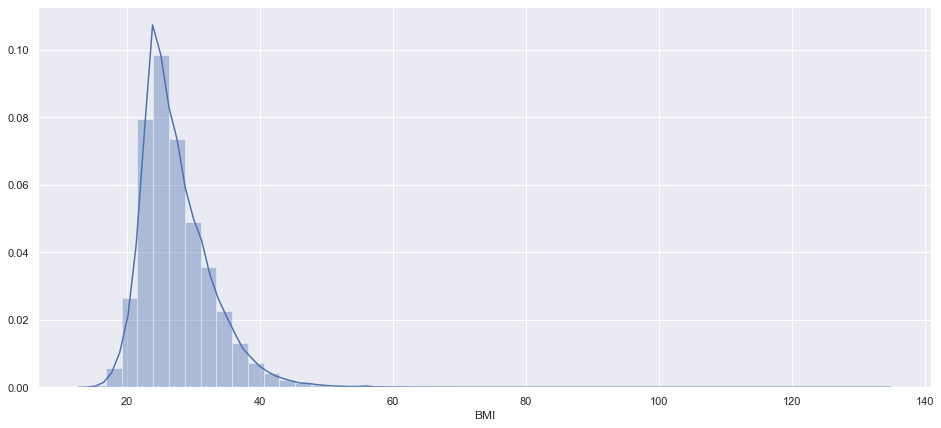

In [34]:
sns.distplot(df3['BMI'])

In [35]:
# Removing outliers: BMI
df3 = df3[(df3['BMI'] < 60)]

<AxesSubplot:xlabel='BMI'>

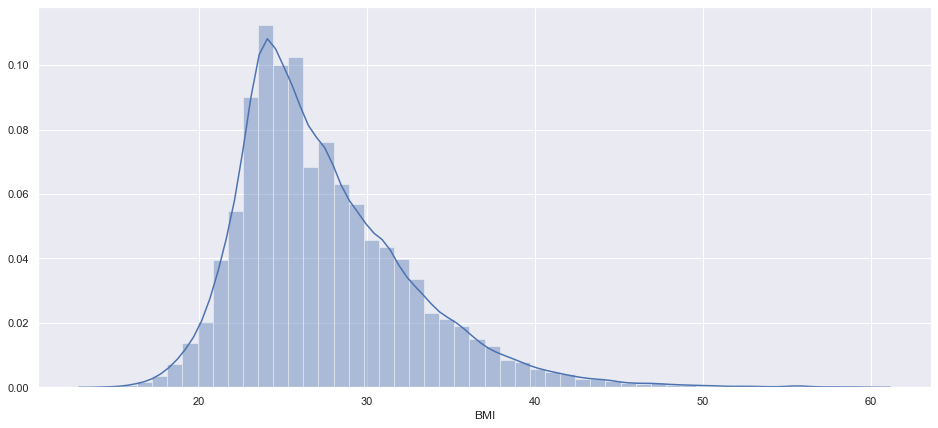

In [36]:
sns.distplot(df3['BMI'])

## 3.2 Columns Selection

<AxesSubplot:>

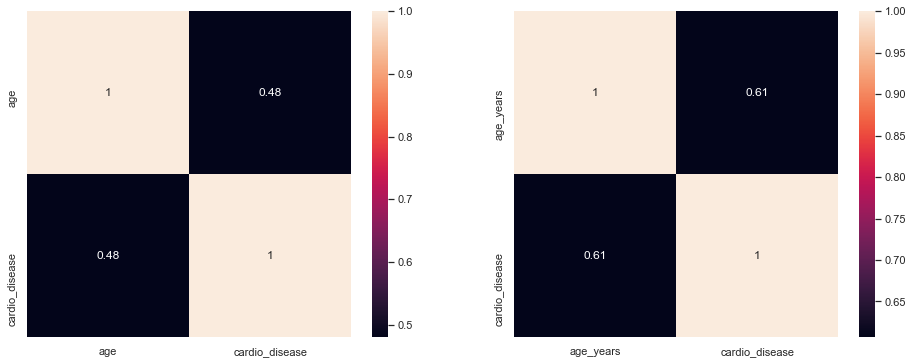

In [37]:
fig = plt.figure(figsize = (16,6))

plt.subplot (1,2,1)
aux1 = df3[['age', 'cardio_disease']].groupby ('age').mean().reset_index()
sns.heatmap(aux1.corr(method= 'pearson'), annot = True)

plt.subplot (1,2,2)
aux2 = df3[['age_years', 'cardio_disease']].groupby ('age_years').mean().reset_index()
sns.heatmap(aux2.corr(method= 'pearson'), annot = True)

In [38]:
cols_drop = ['age', 'id']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0 EXPLORATORY DATA ANALYSIS

In [39]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

<AxesSubplot:xlabel='cardio_disease'>

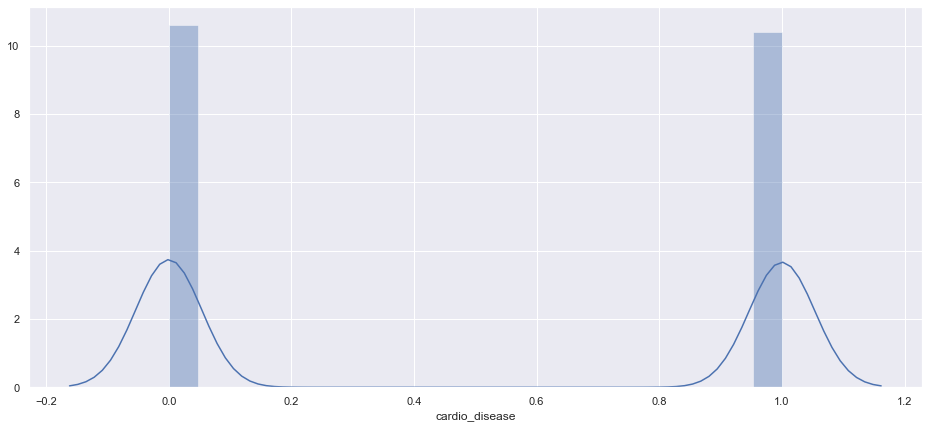

In [40]:
sns.distplot(df4['cardio_disease'])

### 4.1.2 Numerical Variable

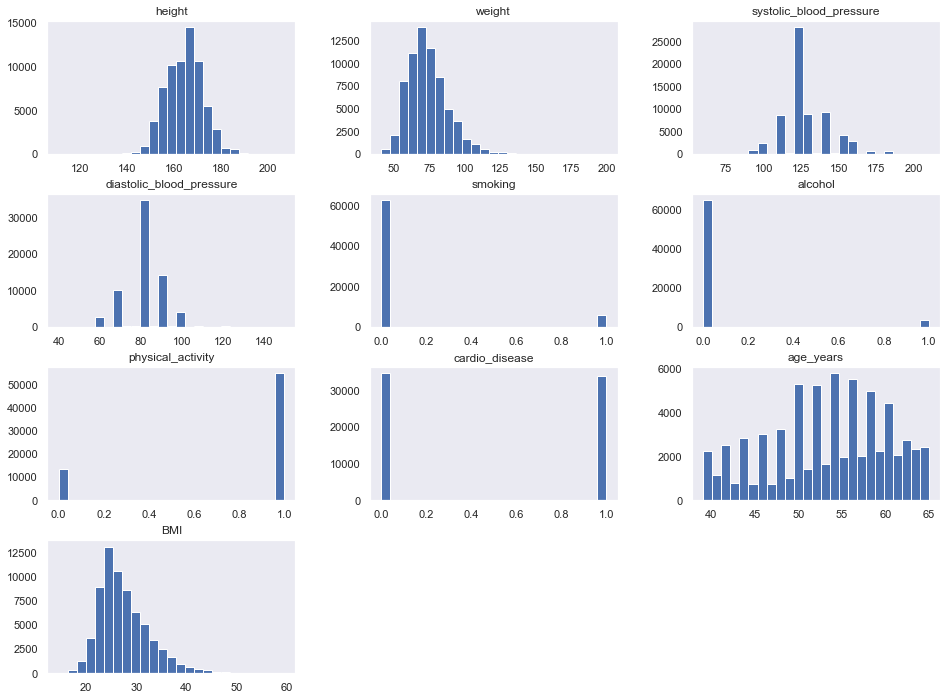

In [41]:
num_attributes = df4.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df4.select_dtypes(exclude = ['int64', 'int32', 'float64'])

fig = plt.figure(figsize = (16,12))
num_attributes.hist(bins = 25, ax = fig.gca(), grid = False);

In [42]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - Std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,height,111.00,207.00,96.00,164.431711,165.00,7.899073,0.028388,0.635794
1,weight,41.00,200.00,159.00,74.128964,72.00,14.158155,0.960214,2.043286
2,systolic_blood_pressure,60.00,210.00,150.00,126.586258,120.00,16.611417,0.843994,1.445763
3,diastolic_blood_pressure,40.00,150.00,110.00,81.350004,80.00,9.520244,0.421541,2.129185
4,smoking,0.00,1.00,1.00,0.088110,0.00,0.283455,2.906276,6.446627
5,alcohol,0.00,1.00,1.00,0.053572,0.00,0.225171,3.965322,13.724178
6,physical_activity,0.00,1.00,1.00,0.803258,1.00,0.397535,-1.525726,0.327849
7,cardio_disease,0.00,1.00,1.00,0.494939,0.00,0.499974,0.020246,-1.999648
8,age_years,39.11,64.97,25.86,53.327742,53.97,6.757883,-0.303782,-0.829932
9,BMI,14.50,59.50,45.00,27.456098,26.30,5.191434,1.192822,2.372411


### 4.1.3 Categorical Variable

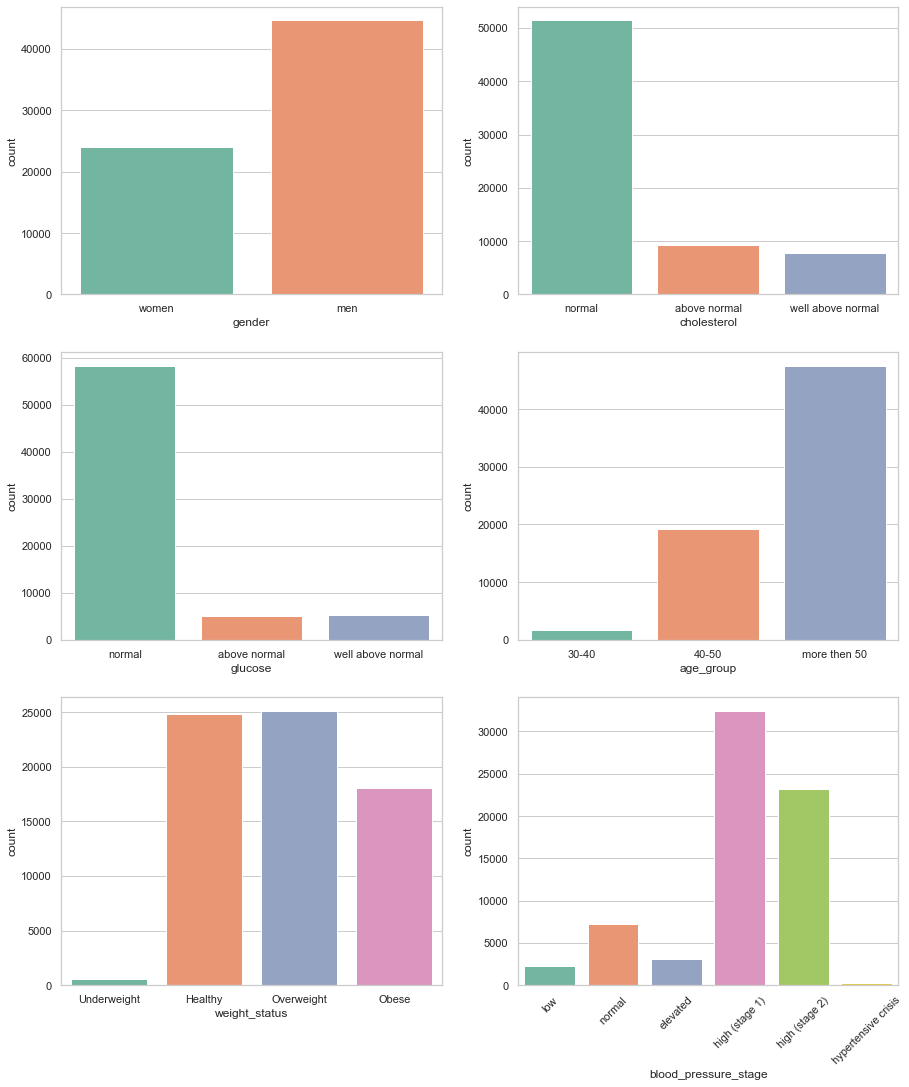

In [43]:
fig = plt.figure(figsize = (15,18))
sns.set_style("whitegrid")
sns.color_palette("Set2")

# gender
plt.subplot (3,2,1)
sns.countplot(df4['gender'], palette = 'Set2')

# cholesterol
plt.subplot (3,2,2)
sns.countplot(df4['cholesterol'], palette = 'Set2', order = ['normal', 'above normal', 'well above normal'])

# glucose
plt.subplot (3,2,3)
sns.countplot(df4['glucose'], palette = 'Set2')

# age_group
plt.subplot (3,2,4)
sns.countplot(df4['age_group'], palette = 'Set2', order = ['30-40', '40-50', 'more then 50'])

# weight_status
plt.subplot (3,2,5)
sns.countplot(df4['weight_status'], palette = 'Set2', order = ['Underweight', 'Healthy', 'Overweight', 'Obese'])

# blood_pressure_stage
plt.subplot (3,2,6)
sns.countplot(df4['blood_pressure_stage'], palette = 'Set2', order=["low", "normal", 'elevated', 'high (stage 1)', 'high (stage 2)', 'hypertensive crisis'])
plt.xticks(rotation = 45);

## 4.2 Bivariate Analysis

### H1: People with hipertension should have more cardio disease.
**TRUE.** People with hipertension HAVE MORE cardio disease.

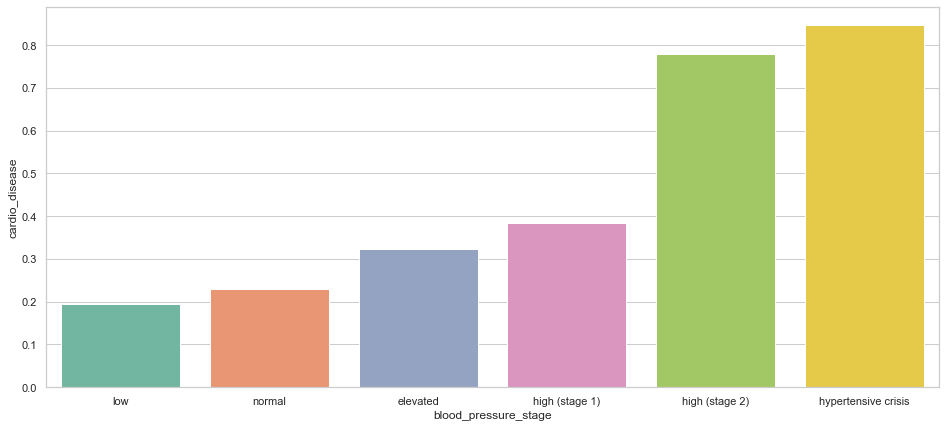

In [44]:
aux1 = df4[['blood_pressure_stage', 'cardio_disease']].groupby('blood_pressure_stage').mean().reset_index()
sns.barplot (x = 'blood_pressure_stage', y = 'cardio_disease', data = aux1, palette = 'Set2', order=["low", "normal", 'elevated', 'high (stage 1)', 'high (stage 2)', 'hypertensive crisis']);

### H2: People with diabetes should have more cardio disease.
**TRUE.** People with diabetes HAVE MORE cardio disease.

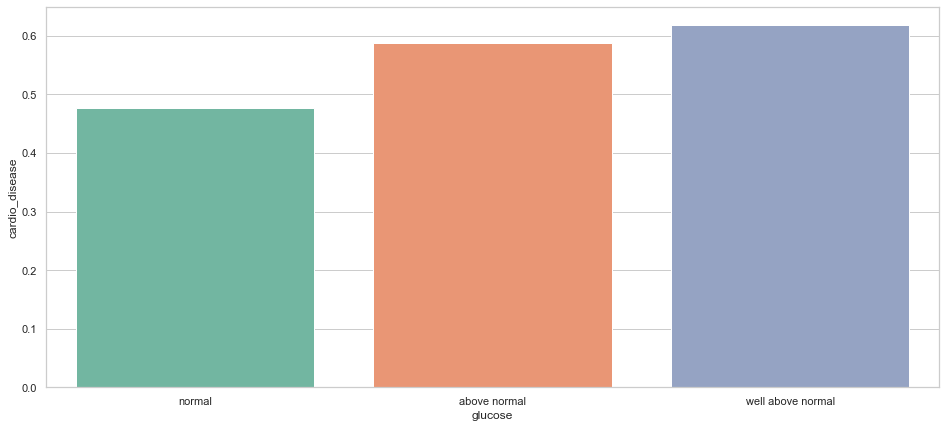

In [45]:
aux1 = df4[['glucose', 'cardio_disease']].groupby('glucose').mean().reset_index()
sns.barplot (x = 'glucose', y = 'cardio_disease', data = aux1, palette = 'Set2', order = ['normal', 'above normal', 'well above normal']);

### H3: People with systolic blood pressure higher then 140 should have more cardio disease.
**TRUE.** People with systolic blood pressure higher then 140 HAVE MORE cardio disease.

<AxesSubplot:>

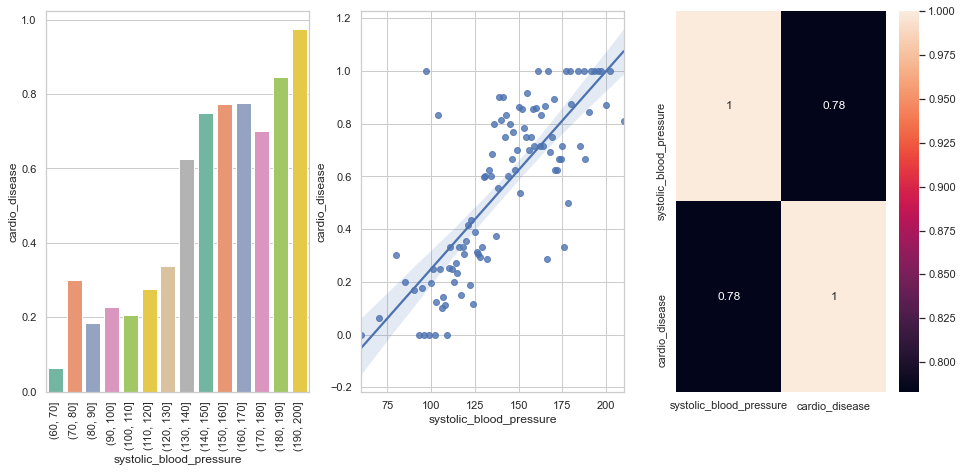

In [46]:
aux1 = df4[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()

plt.subplot (1,3,1)
bins = list(np.arange(60, 210, 10))
aux1['systolic_blood_pressure'] = pd.cut (aux1['systolic_blood_pressure'], bins = bins)
aux2 = aux1[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()
sns.barplot (x = 'systolic_blood_pressure', y = 'cardio_disease', data = aux2, palette = 'Set2')
plt.xticks(rotation = 90);

plt.subplot (1,3,2)
aux3 = df4[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()
sns.regplot(x = 'systolic_blood_pressure', y = 'cardio_disease', data = aux3);

plt.subplot (1,3,3)
sns.heatmap(aux3.corr(method= 'pearson'), annot = True)

### H4: People with systolic blood pressure lower then 90 should have more cardio disease.
**FALSE.**  People with systolic blood pressure lower then 90 HAVE LESS cardio disease.

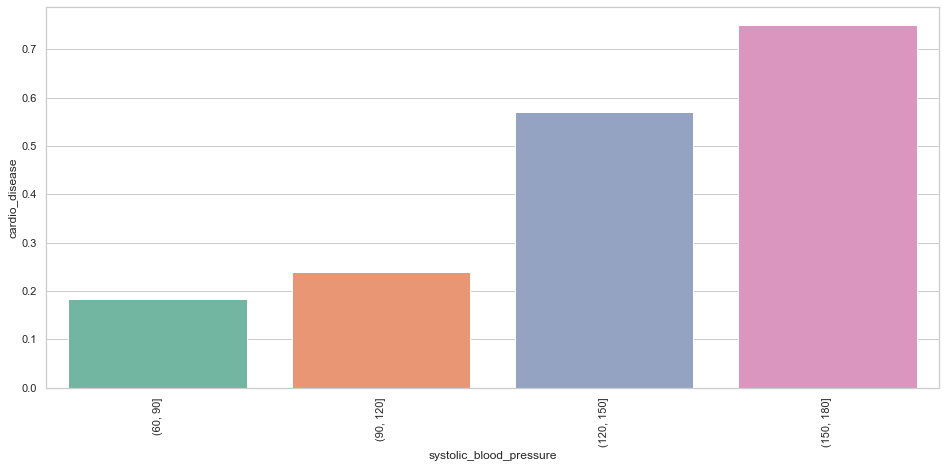

In [47]:
aux1 = df4[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()

bins = list(np.arange(60, 210, 30))
aux1['systolic_blood_pressure'] = pd.cut (aux1['systolic_blood_pressure'], bins = bins)
aux2 = aux1[['systolic_blood_pressure', 'cardio_disease']].groupby('systolic_blood_pressure').mean().reset_index()
sns.barplot (x = 'systolic_blood_pressure', y = 'cardio_disease', data = aux2, palette = 'Set2')
plt.xticks(rotation = 90);

### H5: People with diastolic blood pressure higher then 90 should have more cardio disease.
**TRUE.** People with diastolic blood pressure higher then 90 HAVE MORE cardio disease.

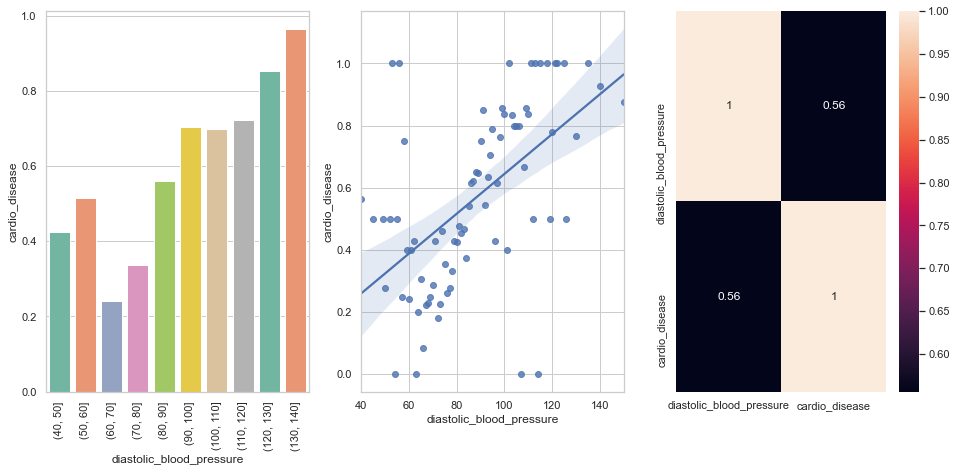

In [48]:
aux1 = df4[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()

plt.subplot (1,3,1)
bins = list(np.arange(40, 150, 10))
aux1['diastolic_blood_pressure'] = pd.cut (aux1['diastolic_blood_pressure'], bins = bins)
aux2 = aux1[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()
sns.barplot (x = 'diastolic_blood_pressure', y = 'cardio_disease', data = aux2, palette = 'Set2')
plt.xticks(rotation = 90);

plt.subplot (1,3,2)
aux3 = df4[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()
sns.regplot(x = 'diastolic_blood_pressure', y = 'cardio_disease', data = aux3);

plt.subplot (1,3,3)
sns.heatmap(aux3.corr(method= 'pearson'), annot = True);

### H6: People with diastolic blood pressure lower then 60 should have more cardio disease.
**TRUE.** People with diastolic blood pressure lower then 60 HAVE MORE cardio disease THEN people with 60-80 diastolic blood pressure.

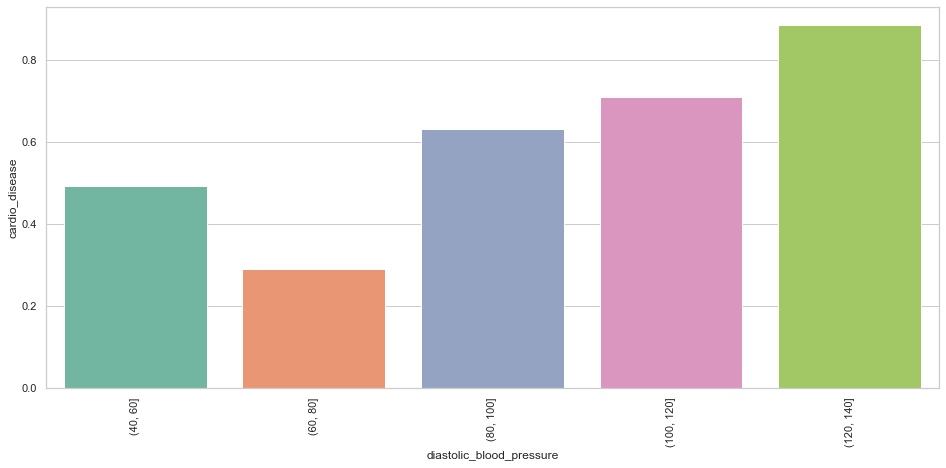

In [49]:
aux1 = df4[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()

bins = list(np.arange(40, 150, 20))
aux1['diastolic_blood_pressure'] = pd.cut (aux1['diastolic_blood_pressure'], bins = bins)
aux2 = aux1[['diastolic_blood_pressure', 'cardio_disease']].groupby('diastolic_blood_pressure').mean().reset_index()
sns.barplot (x = 'diastolic_blood_pressure', y = 'cardio_disease', data = aux2, palette = 'Set2')
plt.xticks(rotation = 90);

### H7: People with higher cholesterol should have more cardio disease.
**TRUE.** People with higher cholesterol HAVE MORE cardio disease.

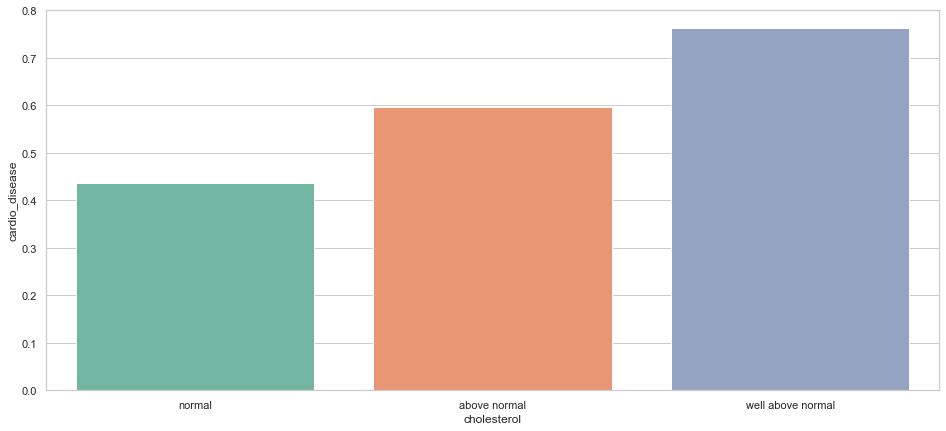

In [50]:
aux1 = df4[['cholesterol', 'cardio_disease']].groupby('cholesterol').mean().reset_index()
sns.barplot (x = 'cholesterol', y = 'cardio_disease', data = aux1, palette = 'Set2', order = ['normal', 'above normal', 'well above normal']);

### H8: Men should have more cardio disease then women.
**FALSE.** Men suffer a little LESS heart disease than women. 

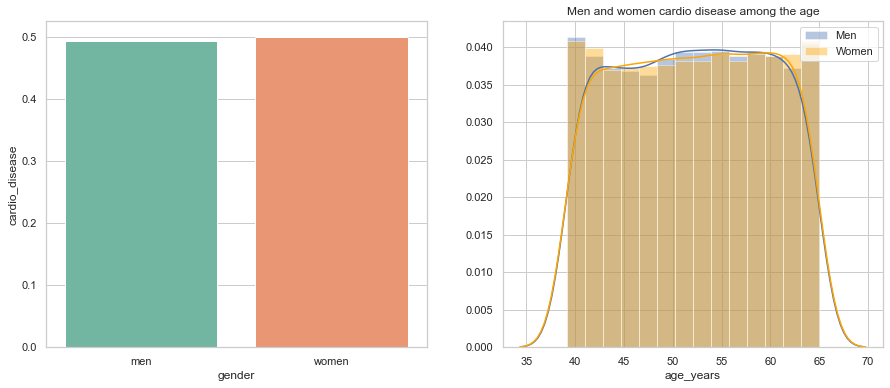

In [51]:
plt.subplots(figsize=(15,6))

plt.subplot (1,2,1)
aux1 = df4[['gender', 'cardio_disease']].groupby('gender').mean().reset_index()
sns.barplot (x = 'gender', y = 'cardio_disease', data = aux1, palette = 'Set2');

plt.subplot (1,2,2)
aux2 = df4[df4['gender'] == 'men'][['age_years','cardio_disease']].groupby('age_years').mean().reset_index()
aux3 = df4[df4['gender'] == 'women'][['age_years','cardio_disease']].groupby('age_years').mean().reset_index()

sns.distplot(aux2['age_years'], label='Men');
sns.distplot(aux3['age_years'], color='orange', label='Women');
plt.title('Men and women cardio disease among the age');
plt.legend();

### H9: Obese people should have more cardio disease.
**TRUE.**  Obese people HAVE MORE cardio disease.

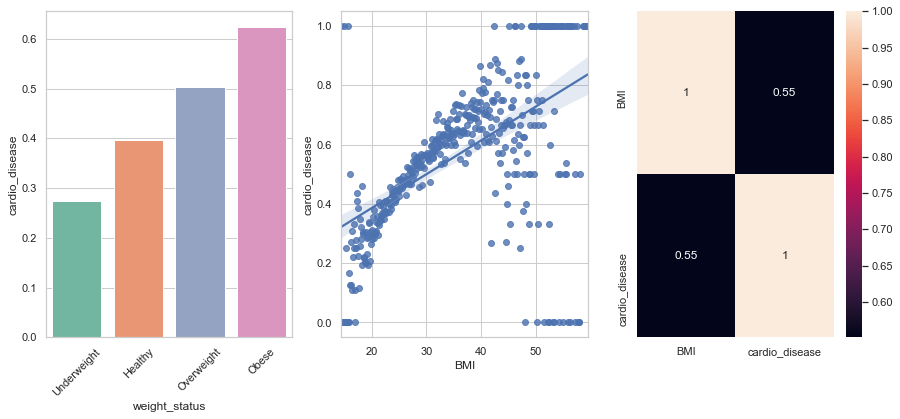

In [52]:
plt.subplots(figsize=(15,6))

plt.subplot (1,3,1)
aux1 = df4[['weight_status', 'cardio_disease']].groupby('weight_status').mean().reset_index()
sns.barplot (x = 'weight_status', y = 'cardio_disease', data = aux1, palette = 'Set2', order = ['Underweight', 'Healthy', 'Overweight', 'Obese']);
plt.xticks(rotation = 45);

plt.subplot (1,3,2)
aux2 = df4[['BMI', 'cardio_disease']].groupby('BMI').mean().reset_index()
sns.regplot(x = 'BMI', y = 'cardio_disease', data = aux2);

plt.subplot (1,3,3)
sns.heatmap(aux2.corr(method= 'pearson'), annot = True);

### H10: Height should not interfere with the likelihood of cardio disease.
**TRUE.** Height DON'T INTERFERE with the likelihood of cardio disease.

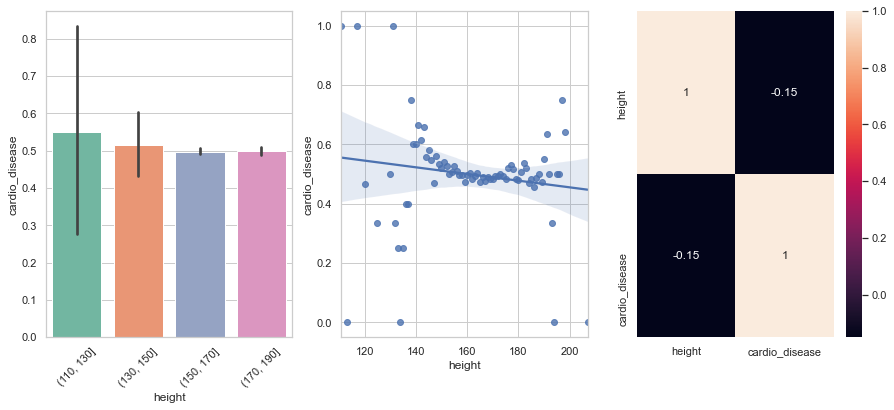

In [53]:
plt.subplots(figsize=(15,6))

plt.subplot (1,3,1)
aux1 = df4[['height', 'cardio_disease']].groupby('height').mean().reset_index()
bins = list(np.arange(110, 210, 20))
aux1['height'] = pd.cut (aux1['height'], bins = bins)
aux2 = aux1[['height', 'cardio_disease']].groupby('height').mean().reset_index()
sns.barplot (x = 'height', y = 'cardio_disease', data = aux1, palette = 'Set2');
plt.xticks(rotation = 45);

plt.subplot (1,3,2)
aux3 = df4[['height', 'cardio_disease']].groupby('height').mean().reset_index()
sns.regplot(x = 'height', y = 'cardio_disease', data = aux3);

plt.subplot (1,3,3)
sns.heatmap(aux3.corr(method= 'pearson'), annot = True);

### H11: Elderly people should have more cardio disease.
**TRUE.** Elderly people HAVE MORE cardio disease.

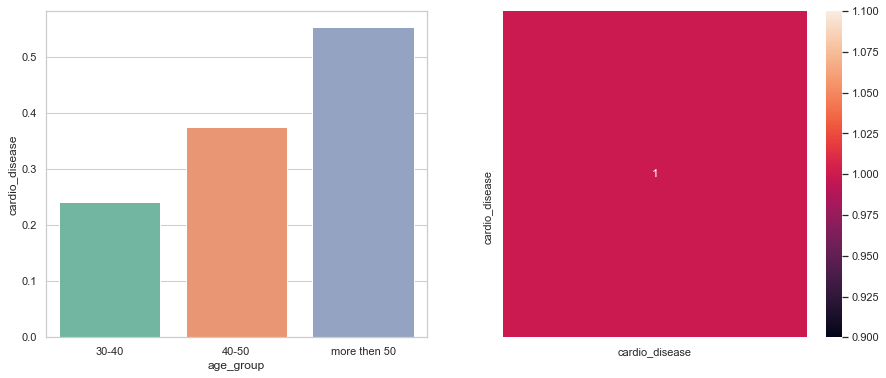

In [54]:
plt.subplots(figsize=(15,6))

plt.subplot (1,2,1)
aux1 = df4[['age_group', 'cardio_disease']].groupby('age_group').mean().reset_index()
sns.barplot (x = 'age_group', y = 'cardio_disease', data = aux1, palette = 'Set2');

plt.subplot (1,2,2)
sns.heatmap(aux2.corr(method= 'pearson'), annot = True);

### H12: People who practice physical activities should have less cardio disease.
**TRUE.** People who practice physical activity REGULARLY HAVE LESS cardio disease.

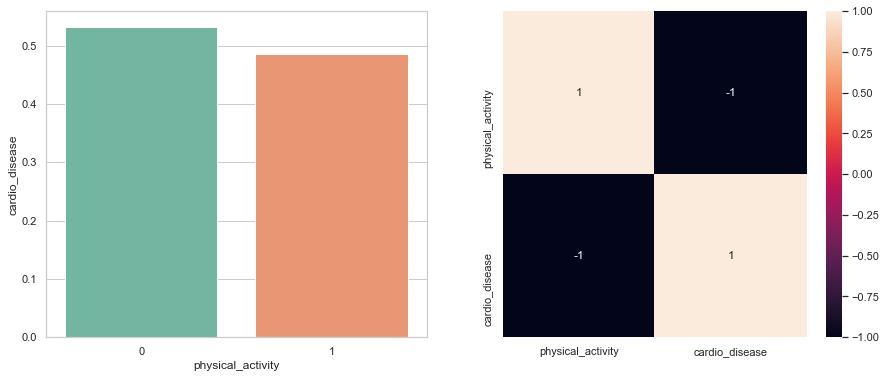

In [55]:
plt.subplots(figsize=(15,6))

plt.subplot (1,2,1)
aux1 = df4[['physical_activity', 'cardio_disease']].groupby('physical_activity').mean().reset_index()
sns.barplot (x = 'physical_activity', y = 'cardio_disease', data = aux1, palette = 'Set2');

plt.subplot (1,2,2)
sns.heatmap(aux1.corr(method= 'pearson'), annot = True);

### H13: People who smoke should have more cardio disease.
**FALSE.** People who smoke HAVE LESS cardio disease.

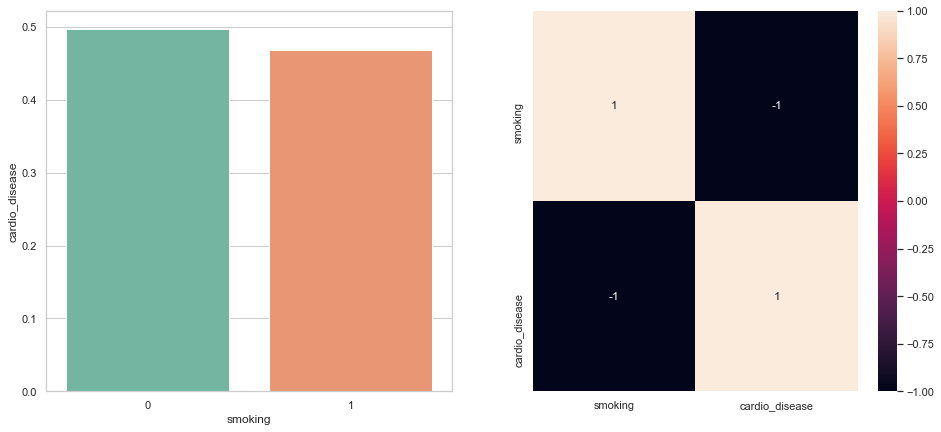

In [56]:
plt.subplot (1,2,1)
aux1 = df4[['smoking', 'cardio_disease']].groupby('smoking').mean().reset_index()
sns.barplot (x = 'smoking', y = 'cardio_disease', data = aux1, palette = 'Set2');

plt.subplot (1,2,2)
sns.heatmap(aux1.corr(method= 'pearson'), annot = True);

### 4.2.1 Hypotheses resume

In [57]:
tab = [['Hypotheses', 'Conclusion', 'Relevance'],
      ['H1', 'True', 'strong'],
      ['H2', 'True', 'strong'],
      ['H3', 'True', 'strong'],
      ['H4', 'False', 'medium'],
      ['H5', 'True', 'medium'],
      ['H6', 'True', 'medium'],
      ['H7', 'True', 'strong'],
      ['H8', 'False', 'weak'],
      ['H9', 'True', 'medium'],
      ['H10', 'True', 'weak'],
      ['H11', 'True', 'strong'],
      ['H12', 'True', 'strong'],
      ['H13', 'False', 'strong'],]

print(tabulate(tab, headers = 'firstrow'))

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            True          strong
H2            True          strong
H3            True          strong
H4            False         medium
H5            True          medium
H6            True          medium
H7            True          strong
H8            False         weak
H9            True          medium
H10           True          weak
H11           True          strong
H12           True          strong
H13           False         strong


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

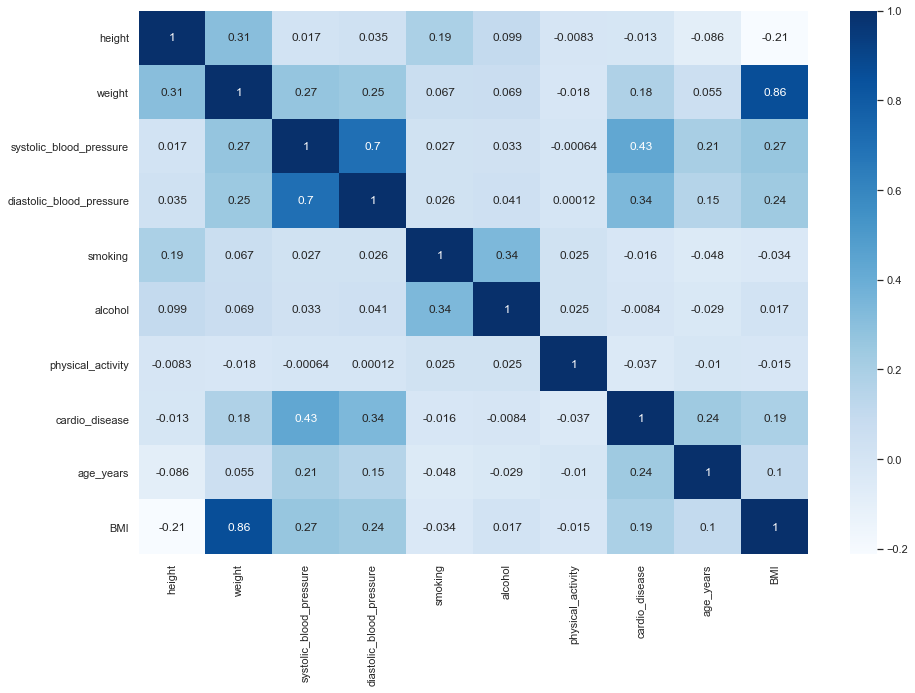

In [64]:
fig = plt.figure(figsize = (15,10))
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True, cmap="Blues");

### 4.3.2 Categorical Attributes

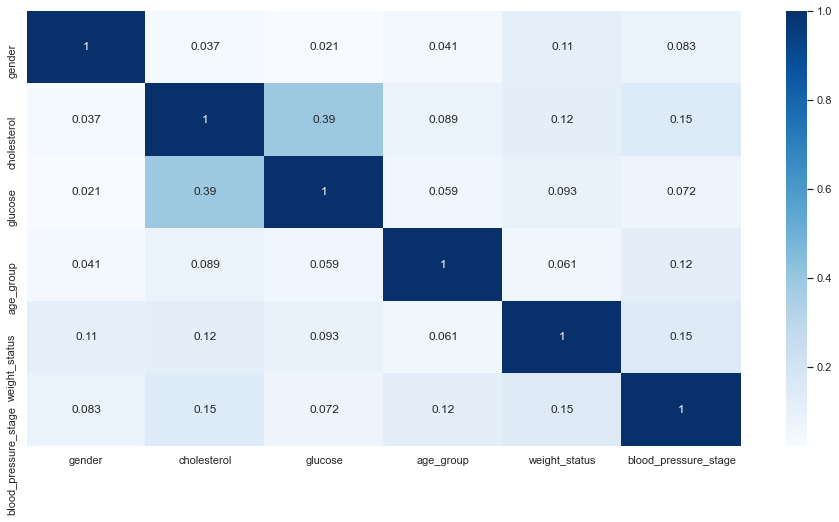

In [63]:
# Only categorical data
a = df4.select_dtypes( include = 'object')

# Calculate cramer v
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['cholesterol'] )
a3 = cramer_v( a['gender'], a['glucose'] )
a4 = cramer_v( a['gender'], a['age_group'] )
a5 = cramer_v( a['gender'], a['weight_status'] )
a6 = cramer_v( a['gender'], a['blood_pressure_stage'] )

a7 = cramer_v( a['cholesterol'], a['gender'] )
a8 = cramer_v( a['cholesterol'], a['cholesterol'] )
a9 = cramer_v( a['cholesterol'], a['glucose'] )
a10 = cramer_v( a['cholesterol'], a['age_group'] )
a11 = cramer_v( a['cholesterol'], a['weight_status'] )
a12 = cramer_v( a['cholesterol'], a['blood_pressure_stage'] )

a13 = cramer_v( a['glucose'], a['gender'] )
a14 = cramer_v( a['glucose'], a['cholesterol'] )
a15 = cramer_v( a['glucose'], a['glucose'] )
a16 = cramer_v( a['glucose'], a['age_group'] )
a17 = cramer_v( a['glucose'], a['weight_status'] )
a18 = cramer_v( a['glucose'], a['blood_pressure_stage'] )

a19 = cramer_v( a['age_group'],  a['gender'] )
a20 = cramer_v( a['age_group'], a['cholesterol'] )
a21 = cramer_v( a['age_group'], a['glucose'] )
a22 = cramer_v( a['age_group'], a['age_group'] )
a23 = cramer_v( a['age_group'],  a['weight_status'] )
a24 = cramer_v( a['age_group'],  a['blood_pressure_stage'] )

a25 = cramer_v( a['weight_status'], a['gender'] )
a26 = cramer_v( a['weight_status'], a['cholesterol'] )
a27 = cramer_v( a['weight_status'], a['glucose'] )
a28 = cramer_v( a['weight_status'], a['age_group'] )
a29 = cramer_v( a['weight_status'],  a['weight_status'] )
a30 = cramer_v( a['weight_status'], a['blood_pressure_stage'] )

a31 = cramer_v( a['blood_pressure_stage'], a['gender'] )
a32 = cramer_v( a['blood_pressure_stage'], a['cholesterol'] )
a33 = cramer_v( a['blood_pressure_stage'], a['glucose'] )
a34 = cramer_v( a['blood_pressure_stage'], a['age_group'] )
a35 = cramer_v( a['blood_pressure_stage'], a['weight_status'] )
a36 = cramer_v( a['blood_pressure_stage'], a['blood_pressure_stage'] )

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3, a4, a5, a6],
                   'cholesterol': [a7, a8, a9, a10, a11, a12],
                   'glucose': [a13, a14, a15, a16, a17, a18],
                   'age_group': [a19, a20, a21, a22, a23, a24],
                   'weight_status': [a25, a26, a27, a28, a29, a30],
                   'blood_pressure_stage': [a31, a32, a33, a34, a35, a36],})

d = d.set_index(d.columns)

fig = plt.figure(figsize = (16,8))
sns.heatmap(d, annot = True, cmap="Blues");

# 5.0 DATA PREPARATION

In [174]:
df5 = df4.copy()

In [175]:
df5.columns

Index(['gender', 'height', 'weight', 'systolic_blood_pressure',
       'diastolic_blood_pressure', 'cholesterol', 'glucose', 'smoking',
       'alcohol', 'physical_activity', 'cardio_disease', 'age_years',
       'age_group', 'BMI', 'weight_status', 'blood_pressure_stage'],
      dtype='object')

## 5.1 Rescaling Features

In [177]:
mms = MinMaxScaler()

# numerical variable different from binary
df5[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_years", "BMI"]] = mms.fit_transform( df5[["height", "weight", "systolic_blood_pressure", "diastolic_blood_pressure", "age_years", "BMI"]])
pickle.dump( mms, open('parameter/numerical_scaler.pkl', 'wb'))


In [178]:
df5.head()

,gender,height,weight,systolic_blood_pressure,diastolic_blood_pressure,cholesterol,glucose,smoking,alcohol,physical_activity,cardio_disease,age_years,age_group,BMI,weight_status,blood_pressure_stage
0,women,0.593750,0.132075,0.333333,0.363636,normal,normal,0,0,1,0,0.436195,more then 50,0.166667,Healthy,high (stage 1)
1,men,0.468750,0.276730,0.533333,0.454545,well above normal,normal,0,0,1,1,0.630704,more then 50,0.453333,Obese,high (stage 2)
2,men,0.562500,0.144654,0.466667,0.272727,well above normal,normal,0,0,0,1,0.485305,more then 50,0.200000,Healthy,high (stage 1)
3,women,0.604167,0.257862,0.600000,0.545455,normal,normal,0,0,1,1,0.354602,40-50,0.315556,Overweight,high (stage 2)
4,men,0.468750,0.094340,0.266667,0.181818,normal,normal,0,0,0,0,0.338747,40-50,0.188889,Healthy,low


## 5.2 Features Transformation

### 5.2.1 Encoding

In [179]:
# ONEHOT ENCODING:
# gender
onehot = ["gender", "smoking", "alcohol", "physical_activity", "cardio_disease"]
df5 = pd.get_dummies(df5, columns = onehot, drop_first=True)

# ORDINAL ENCODING:
# cholesterol
df5["cholesterol"] = df5["cholesterol"].map({"normal": 0, "above normal": 1, "well above normal": 2})
# glucose
df5["glucose"] = df5["glucose"].map({"normal": 0, "above normal": 1, "well above normal": 2})
# age_group
df5["age_group"] = df5["age_group"].map({"less then 30":0 ,"30-40": 1, "40-50": 2, "more then 50": 3})
# weight_status
df5["weight_status"] = df5["weight_status"].map({"Underweight": 0, "Healthy": 1,  "Overweight": 2, "Obese": 3})
# blood_pressure_stage
df5["blood_pressure_stage"] = df5["blood_pressure_stage"].map({"low": 0, "normal": 1, "elevated'": 2, "high (stage 1)": 3,  "high (stage 2)": 4, "hypertensive crisis": 5})



In [180]:
df5.head()

,height,weight,systolic_blood_pressure,diastolic_blood_pressure,cholesterol,glucose,age_years,age_group,BMI,weight_status,blood_pressure_stage,gender_women,smoking_1,alcohol_1,physical_activity_1,cardio_disease_1
0,0.593750,0.132075,0.333333,0.363636,0,0,0.436195,3,0.166667,1,3.0,1,0,0,1,0
1,0.468750,0.276730,0.533333,0.454545,2,0,0.630704,3,0.453333,3,4.0,0,0,0,1,1
2,0.562500,0.144654,0.466667,0.272727,2,0,0.485305,3,0.200000,1,3.0,0,0,0,0,1
3,0.604167,0.257862,0.600000,0.545455,0,0,0.354602,2,0.315556,2,4.0,1,0,0,1,1
4,0.468750,0.094340,0.266667,0.181818,0,0,0.338747,2,0.188889,1,0.0,0,0,0,0,0
